# The Heat Equation

In this notebook, we solve the 1D heat equation with a physics-informed neural network (PINN). This notebook took material from [here](https://github.com/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb) and [here](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/heat.html).

For this notebook, **you need the Tensorflow, Numpy and Matplotlib libraries**. 

* One simple way to get Numpy and Matplotib is to get install Anaconda: https://docs.anaconda.com/free/anaconda/install/index.html
* Tensorflow can be installed from here: https://www.tensorflow.org/install

If you plan to do anything even moderately complex, try to get it installed with gpu support.

We take the 1D heat equation on the following intervals:


$$
\frac{\partial u}{\partial t}=\alpha \frac{\partial^2u}{\partial x^2}, \qquad x \in [0, 1], \quad t \in [0, 1]
$$

For this problem, the boundary/initial conditions are:

$$
u(0,t) = u(1,t)=0, 
$$

$$
u(x,0) = \sin \left(\frac{\pi x}{L}\right),\qquad 0<x<L, \quad n = 1,2,..... 
$$

Use $L = 1$ and $\alpha = 0.4$.

The analytic solution is: 
$$u(x,t) = e^{-\frac{\pi^2 \alpha t}{L^2}} \sin \left( \frac{ \pi x}{L} \right)$$
We will compare the PINN solution with it later.

### Exercises:

1) Find an expression for the solution of the heat equation that satisfies the boundary conditions $u(0,t) = u(1,t)=0, $. Hint: use seperation of variables.

2) Use your expression and the initial condition $u(x,0) = \sin \left(\frac{\pi x}{L}\right)$ to get the solution provided above.

3) What is the solution if $u(x,0) = \sin \left(\frac{n \pi x}{L}\right)$, for some positive integer $n$?

In [1]:
# Import TensorFlow, Numpy and Matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducible results
tf.random.set_seed(42)

In [2]:
# Set parameters
L = 1.
a = 0.4

Next, we define some useful things, like initial conditions, boundary conditions and residual of PDE.

The residual is:

$$f_r(x, t) = \frac{\partial u (x,t)}{\partial t} - \alpha \frac{\partial^2u(x,t)}{\partial x^2} $$

In [3]:
# Set dtype to float32. Higher precision isn't ususally necessary and only slows things down.
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Shorthand for pi
pi = tf.constant(np.pi, dtype=DTYPE)

#Define initial conditions
def fun_u_0 (x):
    return tf.sin(x*pi/L)

#Define boundary conditions
def fun_u_b(x,t):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
    
#Define residual of the PDE
def fun_r(x,t, u_t, u_xx):
    return u_t - a*u_xx  

# Generate points

Here, we generate points. The majority will be in the interior.

In [4]:
# Set number of data points in initial, boundary and interior
N_0 = 50
N_b = 50
N_r = 10000

# Set boundaries
tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.

# Lower bounds of t and x
lb = tf.constant([0,0], dtype=DTYPE)

# Upper bounds of t and x
ub = tf.constant([1,1], dtype=DTYPE)

# Draw uniformly for initial conditions
t_0 = tf.ones((N_0,1))*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis = 1)
              
#Evalutate u_0 at initial conditions   
u_0 = fun_u_0(x_0)

# Draw data points for BC's
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype= DTYPE)
x_b = lb[1] + (ub[1] - lb[1])*tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype =DTYPE)
X_b = tf.concat([t_b, x_b], axis = 1)
              
# Evalutate u at boundary
u_b = fun_u_b(t_b, x_b)
              
# Draw boundary in interior for residual                          
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype= DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis = 1)
              
# Collect boundary and initial conditions in list with 2 elements
X_data = [X_0, X_b]
u_data = [u_0, u_b]

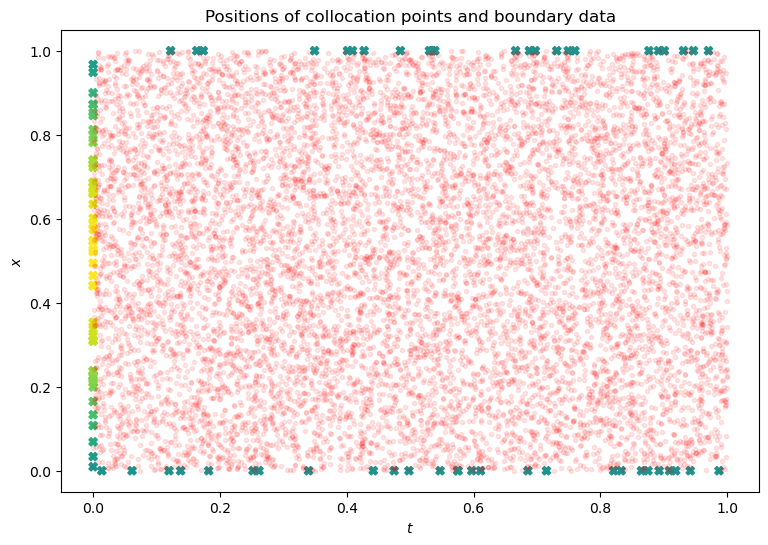

In [5]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Heat.pdf', bbox_inches='tight', dpi=300)

## Set up the neural network

Here we create a dense, fully connected neural network. By default, there are 4 hidden layers and 128 neurons per layer. You can choose other numbers if you want to play around with it.

The scaling layer calls a lambda layer. The lambda layer basically allows you to apply an arbitiary function. Here, we just use it to scale.

We use a $\tanh(x)$ activation over $ReLU(x)$, which is more common in machine learning, because unlike ReLU its second derivate is smooth. This makes satisfiying the PDE easier.

In [6]:
def init_model(num_hidden_layers = 4, num_neurons_per_layer = 128):
    # Initialize a feed-forward model
    model = tf.keras.Sequential()
    
    #Input: t and x
    model.add(tf.keras.Input(2))
    
    # Scale 
    scaling_layer = tf.keras.layers.Lambda(
        lambda x:  2.*(x-lb)/(ub-lb) - 1.  
    )
    model.add(scaling_layer)
    
    # Append layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                activation= tf.keras.activations.get('tanh'),
                kernel_initializer= 'glorot_normal'
                                        )
                )
    # Output is 1 D
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [7]:
 def init_model(num_hidden_layers = 4, num_neurons_per_layer = 128):
    # Initialize a feed-forward model
    model = tf.keras.Sequential()
    
    #Input: t and x
    model.add(tf.keras.Input(2))
    
    # Scale 
    scaling_layer = tf.keras.layers.Lambda(
        lambda x:  2.*(x-lb)/(ub-lb) - 1.  
    )
    model.add(scaling_layer)
    
    # Append layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                activation= tf.keras.activations.get('tanh'),
                kernel_initializer= 'glorot_normal'
                                        )
                )
    # Output is 1 D
    model.add(tf.keras.layers.Dense(1))
    
    return model

Here, we setp up the loss function. We have:

$$ L  = L_{PDE} + L_{IC} + L_{BC}$$

where:

$$ L_{PDE} = \sum_{i=1}^{N_r} |f_r(x_i, t_i)|^2$$

$$ L_{IC} =\sum_{i=1}^{N_0} | u(0, x_i) - e^{-\pi^2 \alpha x_i}\sin (\pi x_i)|^2 $$

$$ L_{BC} = \sum_{i=1}^{N_b} |u(t_i, x_i)|^2$$


In [8]:
def get_r(model, X_r):
    ## This gives the Loss PDE. r is for residual.
    
    # Get t,x
    t, x = X_r[:,0:1], X_r[:, 1:2]
    
    # Predictions given t,x
    u = model(tf.stack([t[:,0], x[:,0]], axis=1))

    # Take relevant gradients
    u_x = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_t = tf.gradients(u,t)[0]
    
    return fun_r(t, x, u_t, u_xx)

def compute_loss(model, X_r, X_data, u_data):
    # Get Loss PDE
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    #Initialize loss with Loss PDE   
    loss = phi_r    
    
    # Now get Loss IC and Loss BC
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i]-u_pred))
    
    return loss
        
def get_grad(model, X_r, X_data, u_data):
    #Get loss and gradient
    """
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape
    """
    loss = compute_loss(model, X_r, X_data, u_data)
    g    = tf.gradients(loss, model.trainable_variables)

    return loss, g

We will initialize the model. We set a decaying learning rate. This is one way of "turning down the noise" during learning.

In [9]:
# Initialize model 
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 400 steps use a learning rate of 0.01
# from 400 - 800: learning rate = 0.006
# from 800 onwards: learning rate = 0.003

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([400,800],[1e-2, 6e-3, 3e-3])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

We define the train step. This is more flexible than model.fit(). 

In [10]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs and history of loss 
N = 1200
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss every 50 iterations
    if i%50 == 0:
        print(f'Iter. {i:04d}: loss = {loss:5.4e}')
        
# Print computation time
print(f'\n Computation time: {time()-t0 :5.4f} seconds')

Iter. 0000: loss = 5.9552e-01
Iter. 0050: loss = 1.4583e-01
Iter. 0100: loss = 7.2221e-02
Iter. 0150: loss = 4.9724e-02
Iter. 0200: loss = 3.2196e-02
Iter. 0250: loss = 1.5582e-02
Iter. 0300: loss = 7.3312e-03
Iter. 0350: loss = 3.6596e-03
Iter. 0400: loss = 1.8995e-03
Iter. 0450: loss = 1.3183e-03
Iter. 0500: loss = 9.4724e-04
Iter. 0550: loss = 7.0626e-04
Iter. 0600: loss = 5.4569e-04
Iter. 0650: loss = 4.3222e-04
Iter. 0700: loss = 3.4729e-04
Iter. 0750: loss = 2.8154e-04
Iter. 0800: loss = 2.2982e-04
Iter. 0850: loss = 2.0774e-04
Iter. 0900: loss = 1.8814e-04
Iter. 0950: loss = 1.7037e-04
Iter. 1000: loss = 1.5434e-04
Iter. 1050: loss = 1.3991e-04
Iter. 1100: loss = 1.2697e-04
Iter. 1150: loss = 1.1541e-04
Iter. 1200: loss = 1.0512e-04

 Computation time: 19.7744 seconds


# Plotting 

Plot loss curve. Often wise to use a log scale in this case.

Text(0.5, 1.0, 'Loss Curve')

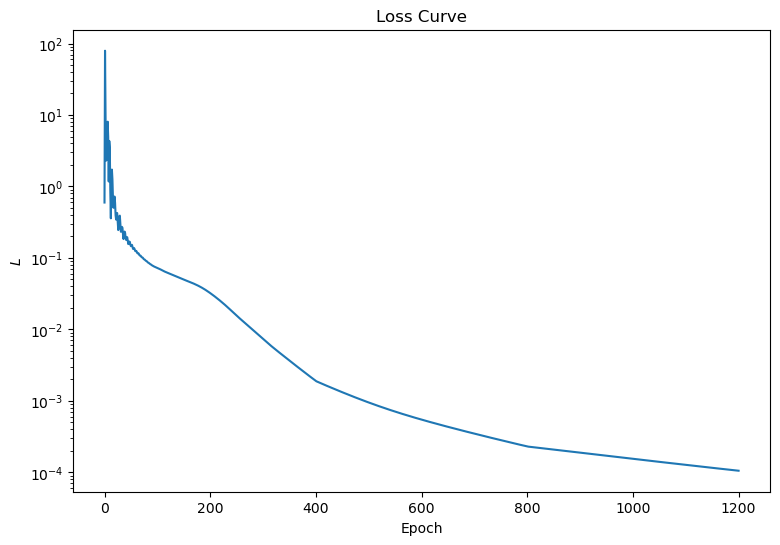

In [11]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist)
ax.set_xlabel('Epoch')
ax.set_ylabel('$L$');
ax.set_title('Loss Curve')

Now, let's see how well the PINN approximates the analytical result.

Text(0.5, 0, 't')

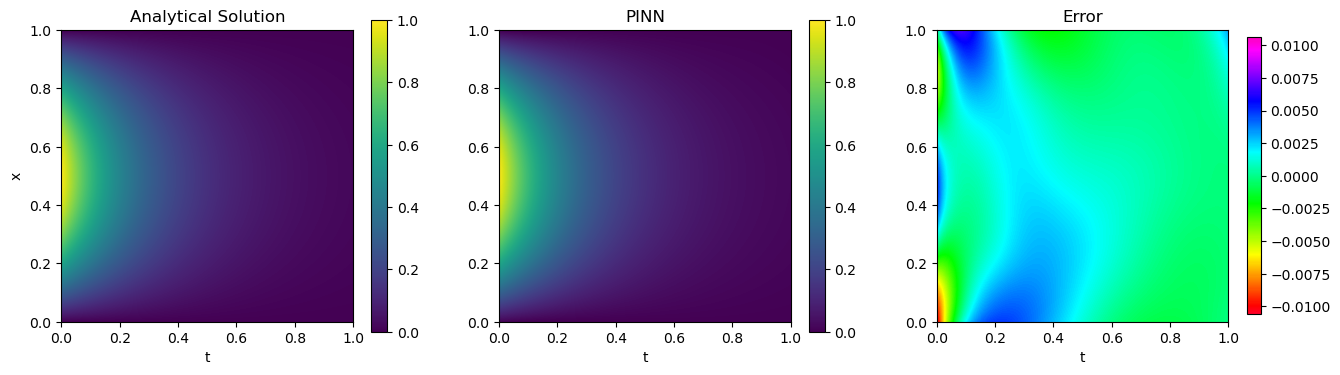

In [12]:
# Set up meshgrid for plotting
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Analyical answer:
def exact_solution(t,x):
    return np.exp(-a*t*(pi/L)**2)*np.sin((pi*x)/L)
    
# Get the values for the analytical solution
u_exact =exact_solution(T,X)

# Reshape into square
U_exact = u_exact.reshape(N+1,N+1)

# Determine predictions of the model
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape model predictoins into square
U_PINN = upred.numpy().reshape(N+1,N+1)

# Create a 3x1 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(16, 9))

# Set colorbar scale for the Analytical and PINN graphs
colobar_min = 0
colobar_max = 1

### Truth ####
plt.subplot(1,3, 1)

# Plot analyic solution, set x,y between 0, 1
plt.imshow(U_exact,
          extent=[0, 1, 0, 1],
          vmin = colobar_min, vmax = colobar_max)

plt.title('Analytical Solution')
plt.xlabel('t')  # x axis is not x. Deal with it.
plt.ylabel('x') 
plt.colorbar(shrink = 0.45)

### PINN ####
plt.subplot(1,3, 2)
plt.imshow(U_PINN,
           extent=[0, 1, 0, 1],
          vmin = colobar_min, vmax = colobar_max)
plt.title('PINN')
plt.xlabel('t') 
plt.colorbar(shrink = 0.45)

### Error ####

error = U_exact - U_PINN

# Get scale for graph
max_abs_error = np.max(np.abs(error))

plt.subplot(1,3, 3)
plt.imshow(U_exact - U_PINN,
          extent=[0, 1, 0, 1],
          cmap = 'gist_rainbow',
          vmin = - max_abs_error, vmax = max_abs_error)
plt.colorbar(shrink = 0.4)
plt.title('Error')
plt.xlabel('t') 

### Excercies

4) Play around with the number of hidden layer, learning rate and number of epochs to see if you can get an even lower MSE.
5) Solve a more complicated PDE, like [Burger's equation](https://en.wikipedia.org/wiki/Burgers%27_equation).